#### Data analysis notebook for Allio Bullet R1 V2 roaster https://aillio.com/?page_id=23112
###### Coffee Roasting by Ryan @f.w.Bennies https://www.instagram.com/f.w.bennies/

#### A work in progress
##### Top goals
###### Load, serialize, and combine data from .json files
###### clean up unwanted data (non 490g roasts or other non-standard batches)
##### summarize and display data (EDA then ML)

##### Would be nice to addtionally have:
- bean density

In [14]:
#################################################
## open each .json in folder and append to df  ##
#################################################
from pathlib import Path
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
pd.set_option('display.max_columns', 55)

# Load from roasTime repository on macOS
home = os.path.expanduser('~')
base_path = os.path.join(home, 'Library/Application Support/roast-time/roasts')
# base_path = Path('/Users/ryanweller/Google Drive/Programing/Python/Coffee/RT3 Profiles') # used on select roast profiles in other folder

df = pd.DataFrame()

for entry in os.listdir(base_path):
    full_path =  Path('%s/%s' % (base_path, entry))
    with full_path.open() as f:
        data = json.loads(f.read())
        df_load = pd.json_normalize(data)
    df = df.append(df_load)
df.sort_values(by='dateTime', inplace = True)
df = df.reset_index()
df = df.drop(columns = ['index'])

#############################
# Clean up and Enrich data  #
#############################
# change dtypes
dtypeList = ['weightGreen','weightRoasted','ambient', 'humidity', 'ambientTemp','roomHumidity']
for d in dtypeList:
    df[d] = pd.to_numeric(df[d], errors='coerce')
    
# combine RT2 ambientTemp and roomHumidity with RT3 ambient and humidity
df['ambient'].where(df['ambient'].isna() == False, df['ambientTemp'].astype(float), inplace = True)
df['humidity'].where(df['humidity'].isna()== False, df['roomHumidity'].astype(float), inplace = True)
df.drop(columns=['ambientTemp', 'roomHumidity','exitTemperature'], inplace =  True)  #dropping old environmental data and exitTemp

# convert dateTime
from datetime import datetime
if df['dateTime'].dtype != 'datetime64[ns]':
    pd.to_numeric(df['dateTime'],errors='coerce')
    for dt in df['dateTime']:
        df['dateTime'] = datetime.fromtimestamp(int(dt/1000))

# Calculate -> weight lost percent = 100 * (green - roasted)/ green #   PLUS OTHERS
df['weightLostPercent'] = 100 * (df['weightGreen'] - df['weightRoasted']) / df['weightGreen']
df['weightLostPercent'].where(df['weightLostPercent'] < 17, np.nan, inplace = True)  ## Future change to 50, 17 is too low

# calulate difference of beanDropTemp and beanChargeTemp (not ITBS, this should relative)   # maybe
df['deltaTemp'] = df['beanDropTemperature'] - df['beanChargeTemperature']

# remove instances where FC was not picked or picked late #
for i, row in df.iterrows():
    if (df.loc[i,'indexFirstCrackStart'] > 2400 or  # if greater then 20 mins (2400 index)
       df.loc[i,'indexFirstCrackStart'] == 0):
            df.loc[i,'indexFirstCrackStart'] == np.nan
    if df.loc[i,'weightRoasted'] < 10:
        df.loc[i,'weightRoasted'] == np.nan
    if df.loc[i,'weightLostPercent'] > 50:
        df.loc[i,'weightLostPercent'] == np.nan
sampleRate = 2
#df.info()

In [15]:
######################################################
# deconstruct temp curves from lists to new curve_df #
######################################################
## data for temp and derivative curve of each  is in a single cell as a list ###
# For each roast (row) extract list of each curve data into a new DF and transpose,
# add indexTime unique to each roast, add curve, append to buddle all roasts curves.
curve_df = pd.DataFrame()
for index, row in df.iterrows():
        temp_curve_df = pd.DataFrame([pd.Series(row['beanTemperature'], name = 'beanTemperature', dtype='float64'), 
                                      pd.Series(row['drumTemperature'], name = 'drumTemperature', dtype='float64'),
                                      pd.Series(row['beanDerivative'], name = 'beanDerivative', dtype='float64'),
                                      pd.Series(row['ibtsDerivative'], name = 'ibtsDerivative', dtype='float64')]).T
        temp_curve_df['indexTime'] = temp_curve_df.index
        temp_curve_df['roastName'] = row['roastName']
        curve_df = curve_df.append(temp_curve_df,ignore_index = True)
curve_df.fillna(value=np.nan)

# TBD create IBTS D and 2nd D
#for i in df.groupby('roastName')ibtsDerivative
#   if i ....

#curve_df.head(1000)

,beanTemperature,drumTemperature,beanDerivative,ibtsDerivative,indexTime,roastName
0,220.4,309.2,-2.8,NaN,0,Roast 49
1,220.4,309.5,-3.8,NaN,1,Roast 49
2,220.4,309.3,-4.4,NaN,2,Roast 49
3,220.3,308.7,-5.1,NaN,3,Roast 49
4,220.3,309.1,-5.5,NaN,4,Roast 49
...,...,...,...,...,...,...
66320,186.1,202.4,2.1,3.7,1123,#45 Kenya Rao's with little to no fan. still c...
66321,186.1,202.5,2.4,3.7,1124,#45 Kenya Rao's with little to no fan. still c...
66322,186.1,202.5,2.2,3.8,1125,#45 Kenya Rao's with little to no fan. still c...
66323,186.2,202.5,2.2,3.7,1126,#45 Kenya Rao's with little to no fan. still c...


In [16]:
########################################################
## Create df of point sets (single entry per profile) ##
########################################################
pd.set_option('display.max_columns', 500)

point_list = ['beanChargeTemperature', 'beanDropTemperature', 'drumChargeTemperature',
       'drumDropTemperature', 'preheatTemperature', 'roastStartIndex', 'roastEndIndex',
       'totalRoastTime', 'indexFirstCrackStart', 'indexFirstCrackEnd', 'indexYellowingStart',
       'weightGreen', 'weightRoasted', 'weightLost', 'weightLostPercent','deltaTemp',
       'roastNumber', 'sampleRate', 'firmware', 'missingSeconds',
       'userId', 'dateTime', 'roastName', 'comments', 'updatedAt',
       'ambient', 'humidity', 'rating', 'beanId']
point_df = pd.DataFrame(df, columns = point_list).reset_index()
point_df.drop(columns='index', inplace = True)
point_df.indexYellowingStart = point_df.indexYellowingStart.fillna(value=np.nan)


In [17]:
### Enrich Point_DF ###

# Enrichment Goals:
# first(MAX ROR) TP, Yellow, FC, weight lost) - Done!
# next (2nd Derivitive, drying-malliard-dev times, and mean ROR between points & phases)
# then (ROR changes after FC )

################################################################################################
##  Find turning point index and index at 165 deg bean Temp (alt to inconsistently picked YP) ##
################################################################################################
roastName_df = curve_df.groupby(['roastName']) 
for name, group in roastName_df:
    minBT = group.beanTemperature.min()  ### Get to 0 ROR indexTime (TP) via first occurance of minBT
    for i,row in group.iterrows():
        if row.beanTemperature == minBT and row.beanDerivative >= 0:   # multiple min points likely, so combined with first point climbing past 0 ROR
           # print (name,i,row)  # Use this NEXT -  TO FIND WHAT 0 and nan problems are! 1/17
            point_df.loc[(point_df.roastName == name),'indexTurningPoint'] = row.indexTime
            point_df.loc[(point_df.roastName == name),'ibtsTurningPointTemp'] = row.drumTemperature
            break
    for i,row in group.iterrows():
        if row.indexTime > 100 and row.drumTemperature >= 165:
            autoYP165 = row.indexTime
            point_df.loc[(point_df.roastName == name),'index165PT'] = autoYP165
            break
    #print (f'autoYP165 = {autoYP165} seconds or {round(autoYP165/2/60,2)} mins for roast (group name) {name} check if correct')

# replace missing or bad YP pick with autoYP165   ### Probably should just switch all YP to autoYP165
point_df.loc[(point_df.indexYellowingStart < 1), 'indexYellowingStart'] = point_df.index165PT
point_df.loc[(point_df.indexYellowingStart.isnull()), 'indexYellowingStart'] = point_df.index165PT
# replace bad FC points with np.nan. # Ryan why didn't you use the .replace() function?
point_df.loc[(point_df.indexFirstCrackStart == 0),'indexFirstCrackStart'] = np.nan
point_df.loc[(point_df.indexFirstCrackStart >10000),'indexFirstCrackStart'] = np.nan
display(point_df.head())

,beanChargeTemperature,beanDropTemperature,drumChargeTemperature,drumDropTemperature,preheatTemperature,roastStartIndex,roastEndIndex,totalRoastTime,indexFirstCrackStart,indexFirstCrackEnd,indexYellowingStart,weightGreen,weightRoasted,weightLost,weightLostPercent,deltaTemp,roastNumber,sampleRate,firmware,missingSeconds,userId,dateTime,roastName,comments,updatedAt,ambient,humidity,rating,beanId,indexTurningPoint,ibtsTurningPointTemp,index165PT
0,220.4,198.4,309.2,198.8,310,0,1412,703,1098.0,0,466.0,900,785.0,NaN,12.777778,-22.0,53,2,499,NaN,73009f59-2d2e-4215-b6ff-961946ee0b80,2021-01-22 20:08:04,Roast 49,NaN,1574525100341,NaN,NaN,3,55c16e48-9b08-4b2f-93d5-8f8b089a5017,146.0,107.1,511.0
1,208.4,206.1,307.6,200.7,310,0,1198,596,898.0,0,458.0,900,0.0,NaN,NaN,-2.3,54,2,499,NaN,73009f59-2d2e-4215-b6ff-961946ee0b80,2021-01-22 20:08:04,Roast 50,NaN,1575011389981,NaN,NaN,2,55c16e48-9b08-4b2f-93d5-8f8b089a5017,142.0,106.9,485.0
2,116.1,177.0,176.4,214.7,175,0,1158,576,958.0,0,525.0,200,175.4,NaN,12.300000,60.9,19,2,531,NaN,73009f59-2d2e-4215-b6ff-961946ee0b80,2021-01-22 20:08:04,Ethiopian Natural Sample Roast 4... Finally (2...,Finally seemed to to get that last little bit ...,1586296416316,NaN,NaN,2,NaN,123.0,100.1,525.0
3,134.5,175.7,221.6,209.0,220,0,1119,557,1018.0,0,542.0,350,312.0,NaN,10.857143,41.2,111,2,523,NaN,73009f59-2d2e-4215-b6ff-961946ee0b80,2021-01-22 20:08:04,20200614a,NaN,1592127337738,NaN,NaN,3,37074ae0-c449-4147-b8c4-3705a0854afc,125.0,104.9,452.0
4,149.7,196.9,240.7,211.6,240,0,1388,692,1104.0,1328,542.0,550,0.0,NaN,NaN,47.2,997,2,540,NaN,73009f59-2d2e-4215-b6ff-961946ee0b80,2021-01-22 20:08:04,Brazil,NaN,1594751239239,NaN,NaN,NaN,NaN,123.0,96.6,557.0


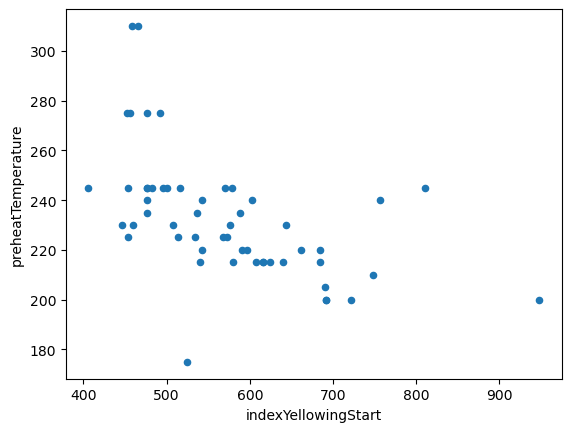

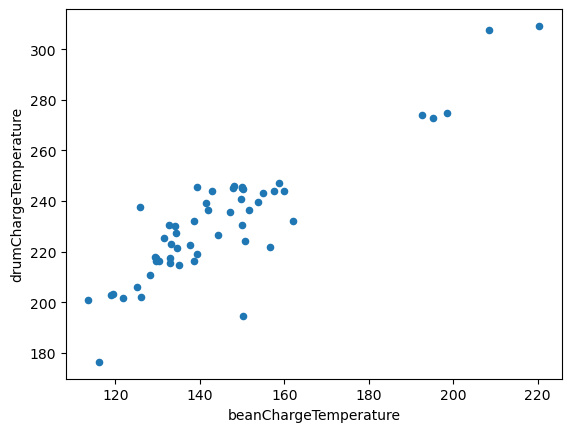

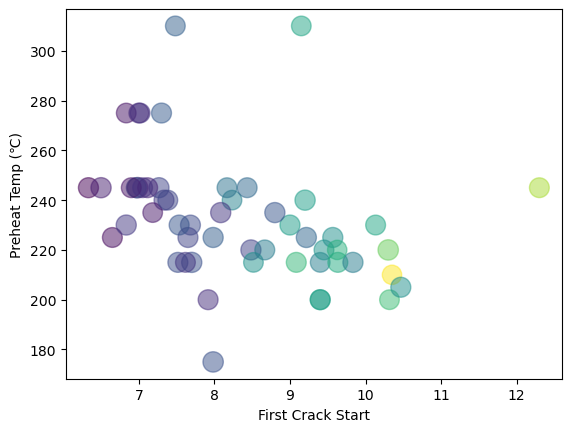

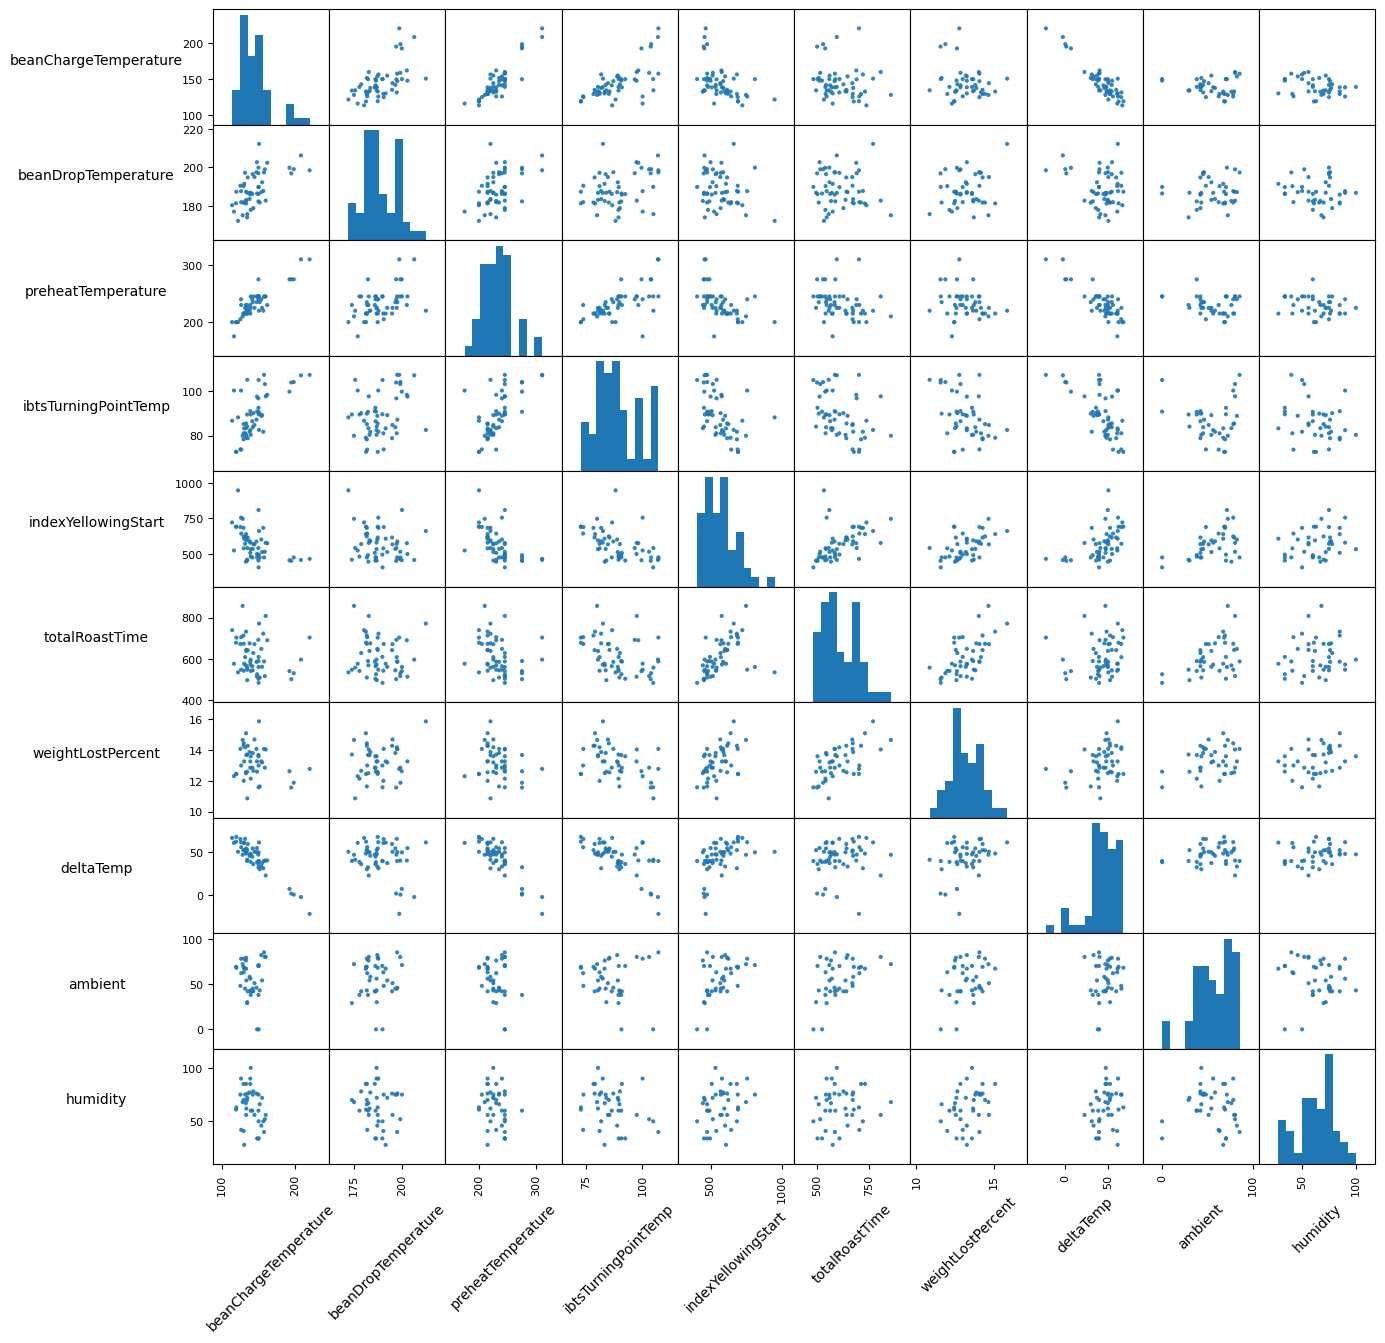

In [18]:
#####################    playing around with plot types and early observations as I learn
## Plot points_df  ##
#####################
# Bar Plot example
#point_df.plot.bar(x='roastName', y=["preheatTemperature","beanDropTemperature"])

# Box Plot example
#point_df['ibtsTurningPointTemp'].plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)

# PH to yellowing pt relation
point_df.plot.scatter(x='indexYellowingStart', y='preheatTemperature')  #['indexYellowingStart', 'indexFirstCrackStart', 'roastEndIndex'])
# difference between thermal probes
point_df.plot.scatter(x= 'beanChargeTemperature', y='drumChargeTemperature')  
plt.show()

# colored scatter example
iFCS = point_df['indexFirstCrackStart']/120
plt.scatter(iFCS, point_df['preheatTemperature'], 
            s=point_df['drumDropTemperature'], c=point_df['roastEndIndex'], alpha=0.5)
plt.xlabel('First Crack Start')
plt.ylabel('Preheat Temp (℃)')
plt.show()


# Scatter Matrix 
from pandas.plotting import scatter_matrix 
# selecting  numerical features 
features = ['beanChargeTemperature', 'beanDropTemperature',
            'preheatTemperature', 'ibtsTurningPointTemp', 'indexYellowingStart',
            'totalRoastTime','weightLostPercent', 'deltaTemp', 
            'ambient', 'humidity']
sm = scatter_matrix(point_df[features], range_padding= .5, alpha = .9, figsize=(15,15))
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
[s.get_yaxis().set_label_coords(-1,0.5) for s in sm.reshape(-1)]

plt.show() 

In [19]:
## finding outliers and specific beans from above
display (df.loc[(df.weightLostPercent > 15),['roastName', 'weightGreen', 'weightRoasted', 'weightLostPercent']])
print ('\n kenyans')
for n in point_df.roastName:
    if n.__contains__("kenya") or n.__contains__("Kenya"):
        print (n)
print ('\n\n short roasts, less than 8 min')   
display (point_df.loc[(point_df.totalRoastTime/60) < 8,['roastName']])


,roastName,weightGreen,weightRoasted,weightLostPercent
5,Abigail's Flat ROR Medium,800,673.0,15.875000
30,#24 PNG Barioda Estate 2nd Actual,490,416.0,15.102041



 kenyans
#13 Kenya Nyeri Githiru AA
oh no.......#23 PNG Barioda Estate 1  lives
oh no.......#24 PNG Barioda Estate 2nd Actual  lives
# 25 Kenya Mix 350/140
# 25 Kenya Mix 350/140
#33 Kenya Gakuyu-Ini AA
#34 Kenya - Soak and watch
#35 Kenya no soak - FC stall, balls
#37 Kenya - fast start. always stalls
#44 Kenya - Rao suggestion
#45 Kenya Rao's with little to no fan. still crashed 40s after FC


 short roasts, less than 8 min


,roastName


LinregressResult(slope=3.9464909413907354, intercept=152.677703047789, rvalue=0.8763006876551528, pvalue=8.516774043329782e-05, stderr=0.6541788164707135)


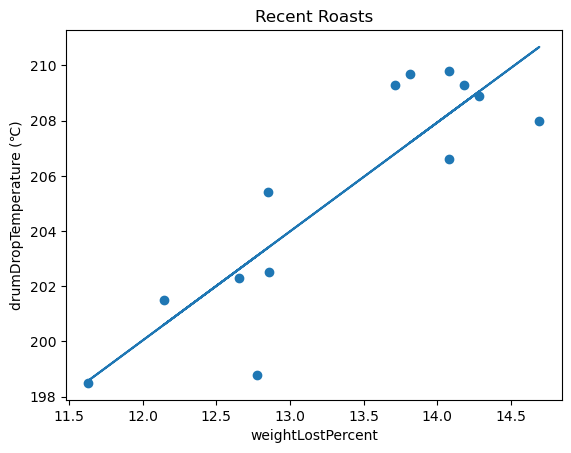




LinregressResult(slope=0.9045977576432438, intercept=191.4439912134009, rvalue=0.20925774640057038, pvalue=0.588954537816684, stderr=1.5977243537256984)


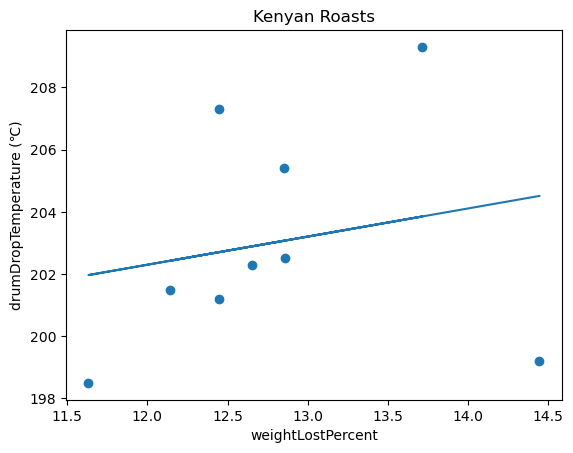

20    #13 Kenya Nyeri Githiru AA
52    #44 Kenya - Rao suggestion
Name: roastName, dtype: object

Text(0, 0.5, 'drumDropTemperature (℃)')

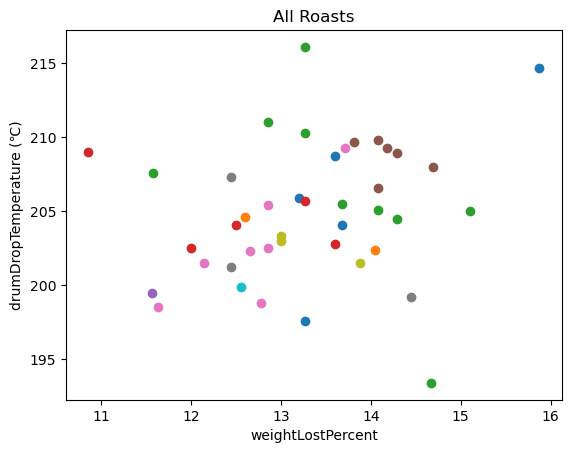

In [20]:
# First pass on Linear Regression
import matplotlib.pyplot as plt
from scipy import stats

## bean id ##
# Kenyan Gakuyu-Ini    55c16e48-9b08-4b2f-93d5-8f8b089a5017
# Ethiopian Yirg   4a557687-d410-4ad2-b504-27b518a9a7ae
beans = ['55c16e48-9b08-4b2f-93d5-8f8b089a5017','4a557687-d410-4ad2-b504-27b518a9a7ae']
bean_df = point_df[point_df.beanId.isin(beans)]
allbean_df = point_df

kenya_list = []
for n in point_df.roastName:
    if n.__contains__("kenya") or n.__contains__("Kenya"):
        kenya_list.append(n)
kenya_df = point_df[point_df.roastName.isin(kenya_list)]

# Regression (y=mx+b) for bean_df
df_no_missing = bean_df[['weightLostPercent','drumDropTemperature','beanId','roastName']].dropna()
allbean_df = point_df[['weightLostPercent','drumDropTemperature','beanId','roastName']].dropna()

x_name = 'weightLostPercent'
y_name = 'drumDropTemperature'

x= df_no_missing[x_name]
y= df_no_missing[y_name]

slope, intercept, r, p, std_err = stats.linregress(x, y)
print (stats.linregress(x, y) )
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))
plt.title('Recent Roasts')
plt.xlabel('weightLostPercent')
plt.ylabel('drumDropTemperature (℃)')
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

# Regression (y=mx+b) for kenya_df
df_no_missing2 = kenya_df[['weightLostPercent','drumDropTemperature','beanId','roastName']].dropna()

x_name = 'weightLostPercent'
y_name = 'drumDropTemperature'

x= df_no_missing2[x_name]
y= df_no_missing2[y_name]

slope, intercept, r, p, std_err = stats.linregress(x, y)
print ('\n\n')
print (stats.linregress(x, y) )
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))
plt.title('Kenyan Roasts')
plt.xlabel('weightLostPercent')
plt.ylabel('drumDropTemperature (℃)')
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

display(df_no_missing2.loc[(df_no_missing2.drumDropTemperature<200),'roastName'])

groups = allbean_df.groupby('beanId')
for name, group in groups:
    plt.plot(group[x_name], group[y_name], marker='o', linestyle='', markersize=6, label=name)
plt.title('All Roasts')
plt.xlabel('weightLostPercent')
plt.ylabel('drumDropTemperature (℃)')
#plt.legend()

In [21]:
## Things that didn't work
#autoYP2 = curve_df[(curve_df.index > indexTP) & (curve_df['drumTemperature'] >= 165) ,curve_df.index]
#print (autoYP2)

########


### Development Notes

##### NEED better fix for bad data (currently replaceing row NAN)
RT2 - no ibtsDerivitive and no uid. (Calculate derivitive for this before staring 2nd D)
 - ibtsDerivative  is NaN is many many older roasts! - fill - ibtsDerivative  is NaN is many many older roasts! - fill
##### Problems
 - Many outliers and messes since 1/26 changes to pulling data from all roasts rather than select roasts

##### RAW DATA Problems
 - bad intial YP (# 25 Kenya Mix 350/140 and prob more.... go thru 1by1..Delete OLD and restore NEW)

##### TEMP FIX
 Some other roast has 0 sec FC time - currently replaceing row NAN (check what line)
 
- 1/17/21 roastName_df and indexTurningPoint in much better shape. however one point is 0 and one is missing (or many different)
- 1/18/21  fixed 165 auto YP with simlar method for iterating over groups for indexTurningPoint. Broke weightLoss
- 1/19/21  cleaned up documentation. removed PNG 24 (quite manually, can't figure out why, found roasts in    
 - Removed Ethiopia # 6 funny story..., also fixed stacked plot by breaking out ax1.scatter into 2 lines and s = 0.03 (very small!)
- 1/24/21  carried over RT2 ambientTemp and roomHumidity to RT3 ambient, humididty columns and dropped old.  Fixed 100% weightLostPercent
 - added simple liner regression of weight loss % and drop temp while removing nans. (Started f.w.bennies instagram)
- 1/25/21 brought in new roasts from RW, fixed up regression to show for specific beans in a list
- 1/26/21 changed to multiload2, cleaned up documentation, load straight out of library/ roasts folder to avoid scraping, found new errors based on loading more data (temp and other strings), fixed., added titles to regression charts, make list for 'kenya' in roast name and plotted results limiting to kenyans
- 1/29/21 uploaded to GitHub, cleaned up some notes and organization

## NEXT - calculate DTR
- How about WL% / DTR (plot wl% vs DTR,   then WL%/DTR vs drop temp!

- fill in ITBS derivitive for RT2 (i think they weren't being captured)]
- 

66325 66325


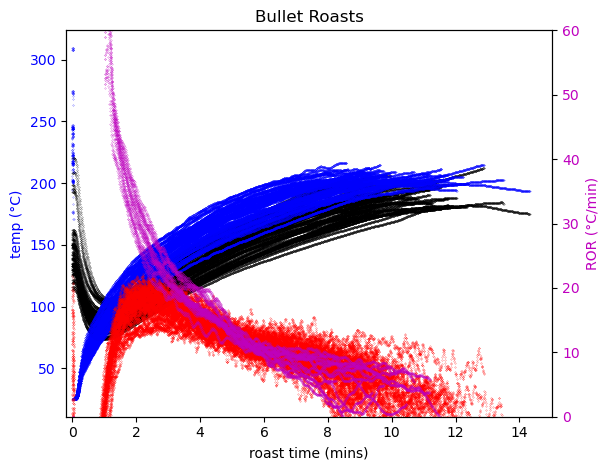

In [22]:
#############################################################  # NEED TO DO - plot better, maybe in groups relative to origin
## Creating full plot of 2 temp curves and associated RORs ##  
#############################################################


from cycler import cycler

temp_list = ['beanTemperature','drumTemperature']
derivative_list = ['beanDerivative','ibtsDerivative']


plt.style.use('default')   #change for future
fig, ax1 = plt.subplots()

ax1.set_xlabel('roast time (mins)')
ax1.set_ylabel('temp (°C)', color='b')
ax1.set_prop_cycle(cycler('color', ['k', 'b']) + cycler('lw', [1, 2])) # necessary to set ax1 parameters before plot
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title("Bullet Roasts") 
ax1.scatter((curve_df.indexTime/sampleRate)/60, curve_df['beanTemperature'], label = 'Bean Temp', s=0.03) #trick is to print these as seperate axes 
ax1.scatter((curve_df.indexTime/sampleRate)/60, curve_df['drumTemperature'], label = 'Drum Temp', s=0.03) #trick is to print these as seperate axes 


print (len((curve_df.indexTime/sampleRate)/60), len(curve_df[temp_list]))

ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
ax2.set_ylabel('ROR (°C/min)', color='m')  # we already handled the x-label with ax1
ax2.set_prop_cycle(cycler('color', ['r', 'm']) + cycler('lw', [1, 2]))
rorList = ['ROR', 'ror']
ax2.scatter((curve_df.indexTime/sampleRate)/60, curve_df['beanDerivative'], label='ROR', s=0.03)
ax2.scatter((curve_df.indexTime/sampleRate)/60, curve_df['ibtsDerivative'], label='ROR', s=0.03)


ax2.tick_params(axis='y', labelcolor='m')
fig.tight_layout()  # otherwise the right y-label can be slightly clipped
plt.ylim([0, 60])
plt.xlim(left=-0.2)
#plt.legend(loc='upper center') # LATER display 4 labels, currently only ROR plots for 2 of 4 curves
plt.show('LineStyle','none')
